In [1]:
import os
import sys
import numpy as np

import PIL
import PIL.Image
import torch
import torchvision
import sys
import copy

import time

sys.path.append('/user_data/mmhender/featsynth/texture_synthesis/code')
import things_utils

sys.path.append('/user_data/mmhender/featsynth/')

from code_utils import filter_utils

things_stim_path = '/user_data/mmhender/stimuli/things/'
orig_stim_path = '/user_data/mmhender/stimuli/featsynth/images_v1'
save_stim_path = '/user_data/mmhender/stimuli/featsynth/images_v1_filtered'


/home/mmhender/imstat_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
n_ims_do=10

concepts_filename = os.path.join(things_stim_path, 'concepts_use.npy')
concepts_use = np.load(concepts_filename,allow_pickle=True).item()
categ_names = concepts_use['categ_names']
concept_names_subsample = concepts_use['concept_names_subsample']
image_names = concepts_use['image_names']
concept_ids_subsample = concepts_use['concept_ids_subsample']
n_categ = len(categ_names)
n_conc_each = len(concept_names_subsample[0])

categ_process = np.arange(n_categ)
conc_process = np.arange(n_conc_each)
ims_process = np.arange(n_ims_do)

ca = 0; categ_ind = categ_process[ca]
categ = categ_names[categ_ind]
        
co = 0; conc_ind = conc_process[co]
conc = concept_names_subsample[categ_ind][conc_ind]
       
ii = 0
target_image_filename = things_utils.get_filename(categ, conc, ii)

In [14]:
name = target_image_filename.split('/')[-1].split('.jpg')[0]

In [7]:
name = 'ostrich_03s'

In [15]:
orig_dir = os.path.join(orig_stim_path, name)

out_dir = os.path.join(save_stim_path, name)

out_dir

which_grid = 5;
n_grid_eachside=1; 
important_layers = ['relu1_1', 'pool1','pool2','pool3','pool4']
layers_do = [1,2,3,4]

filenames_convert = ['orig.png']
filenames_convert += ['grid%d_%dx%d_upto_%s.png'%(which_grid, \
                                                             n_grid_eachside, \
                                                             n_grid_eachside, \
                                                            important_layers[ll])\
                     for ll in layers_do]

In [10]:
file

NameError: name 'file' is not defined

loading from /user_data/mmhender/stimuli/featsynth/images_v1/toucan_01b/orig.png


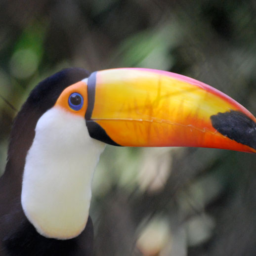

In [16]:
file = filenames_convert[0]
filename_orig = os.path.join(orig_dir, file)
filename_save = os.path.join(out_dir, file)

print('loading from %s'%(filename_orig))

# load it and convert to grayscale format.
# this function uses:
# L = R * 299/1000 + G * 587/1000 + B * 114/1000
image = PIL.Image.open(filename_orig)
image


In [28]:
npix = image.size[0]
image_mat = np.reshape(np.array(image.getdata()), [npix, npix, 3]).astype(np.float64)
image_mat /= 255


In [29]:
import matplotlib.pyplot as plt

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


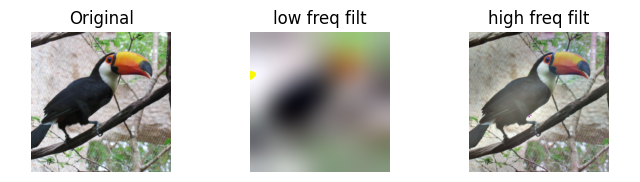

In [10]:
f_lp = filter_utils.filter_lowpass_spatial(image_mat)
f_hp = filter_utils.filter_highpass_spatial(image_mat)

plt.figure(figsize=(8,4))
plt.subplot(2,3,1)
plt.imshow(image_mat)
plt.axis('equal')
plt.axis('off')
plt.title('Original');

plt.subplot(2,3,2)
plt.imshow(f_lp)
plt.axis('equal')
plt.axis('off')
plt.title('low freq filt');

plt.subplot(2,3,3)
plt.imshow(f_hp)
plt.axis('equal')
plt.axis('off')
plt.title('high freq filt');

In [21]:
f_hp

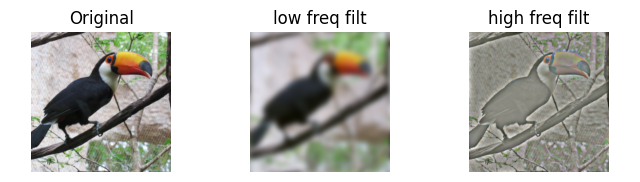

In [18]:
f_lp_freq = filter_utils.filter_lowpass(image_mat, 5)
f_hp_freq = filter_utils.filter_highpass(image_mat, 5)

plt.figure(figsize=(8,4))
plt.subplot(2,3,1)
plt.imshow(image_mat)
plt.axis('equal')
plt.axis('off')
plt.title('Original');

plt.subplot(2,3,2)
# plt.pcolormesh(f_lp_freq[:,:,0])
plt.imshow(f_lp_freq)
plt.axis('equal')
plt.axis('off')
plt.title('low freq filt');

plt.subplot(2,3,3)
# plt.pcolormesh(f_hp_freq[:,:,0])
plt.imshow(f_hp_freq)
plt.axis('equal')
plt.axis('off')
plt.title('high freq filt');

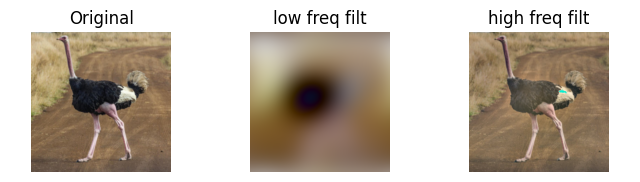

In [34]:
f_lp_freq = filter_utils.filter_lowpass(image_mat, 26)
f_hp_freq = filter_utils.filter_highpass(image_mat, 26)

plt.figure(figsize=(8,4))
plt.subplot(2,3,1)
plt.imshow(image_mat)
plt.axis('equal')
plt.axis('off')
plt.title('Original');

plt.subplot(2,3,2)
# plt.pcolormesh(f_lp_freq[:,:,0])
plt.imshow(f_lp_freq)
plt.axis('equal')
plt.axis('off')
plt.title('low freq filt');

plt.subplot(2,3,3)
# plt.pcolormesh(f_hp_freq[:,:,0])
plt.imshow(f_hp_freq)
plt.axis('equal')
plt.axis('off')
plt.title('high freq filt');

In [54]:
image = image_mat

npix = image.shape[0]
means_orig = [np.mean(image[:,:,cc]) for cc in range(3)]

xfreq = np.abs(np.linspace(-0.5, 0.5, npix))
yfreq = np.abs(np.linspace(-0.5, 0.5, npix))
xgrid, ygrid = np.meshgrid(xfreq, yfreq)

# Frequency domain representation of the gaussian kernel has a sigma, related to the 
# spatial domain sigma by: sigma_spat = 1/(2*pi*sigma_freq)
sigma_freq = 1/(2*np.pi*sigma)

lp_gauss = np.exp(-((xgrid)**2 + (ygrid)**2)/(2*sigma_freq**2))
lp_gauss /= np.max(lp_gauss) # make sure it spans 0-1
# highpass filter is 1-lowpass filter
hp_gauss = 1 - lp_gauss
# hp_gauss /= np.sum(hp_gauss)
filter_freq = hp_gauss

f = np.zeros(np.shape(image))

cc = 0;
# for cc in range(3):
vals = filter_utils.filter_fft(image[:,:,cc], filter_freq)


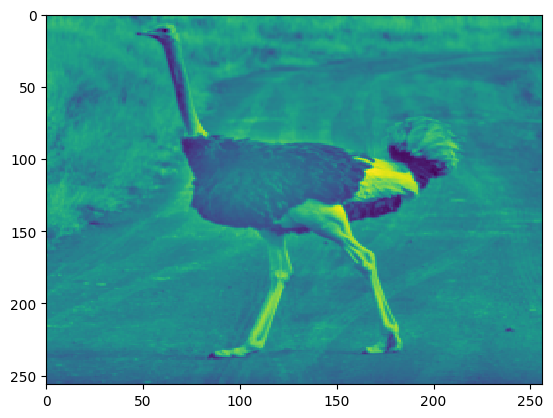

In [48]:
plt.figure()
plt.pcolormesh(vals);
plt.gca().invert_yaxis()

In [55]:
vals -= np.mean(vals) # mean-center values
vals /= (np.max(np.abs(vals))*2) # make them span [-0.5, 0.5]
vals += means_orig[cc] # adjust mean
        

In [57]:
np.max(vals)

1.0399667178883272

In [51]:
vals = (np.abs(vals)*255).astype(np.uint8)

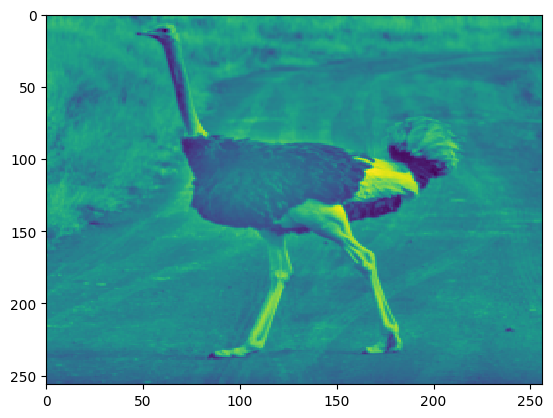

In [58]:
plt.figure()
plt.pcolormesh(np.abs(vals)*255);
plt.gca().invert_yaxis()

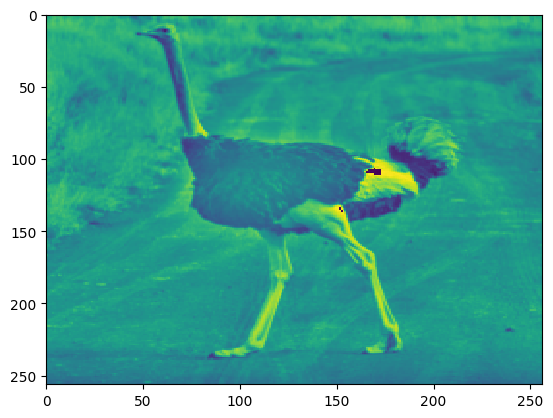

In [60]:
plt.figure()
plt.pcolormesh((np.abs(vals)*255).astype(np.uint8));
plt.gca().invert_yaxis()

In [61]:
np.array([260, 265]).astype(np.uint8)

array([4, 9], dtype=uint8)

In [62]:
np.minimum(np.array([-4, 6]), 0)

array([-4,  0])

In [62]:
np.minimum(np.array([-4, 6]), 0)

array([-4,  0])

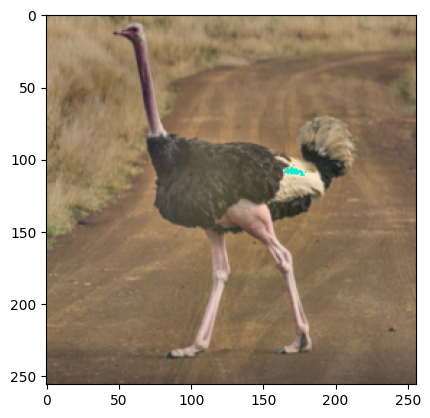

In [36]:
plt.figure()
plt.imshow(f_hp_freq)

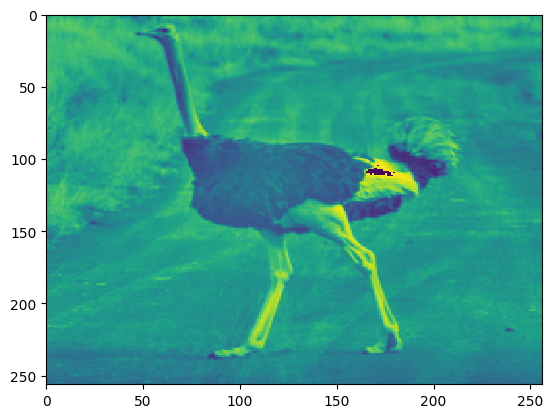

In [44]:
plt.figure()
plt.pcolormesh(f_hp_freq[:,:,0]);
plt.gca().invert_yaxis()

In [45]:
f_hp_freq[100:120, 160:170,0]

array([[177, 190, 224, 237, 243, 216, 135,  88, 114, 193],
       [130, 124, 151, 186, 218, 243, 227, 147, 107, 158],
       [103, 101,  95, 131, 164, 217, 233, 225, 191, 214],
       [ 87,  80,  79,  90,  99, 134, 163, 213, 242, 248],
       [ 87,  89,  92,  78,  79,  94, 100, 136, 223, 253],
       [ 88,  91, 102, 101,  91,  80,  83, 132, 194, 246],
       [ 70,  73,  88, 104, 108, 146, 164, 203, 244,   4],
       [ 65,  65,  77, 114, 179, 230,   3,   4,   6,   8],
       [ 69,  77,  70, 111, 232,   6,   8,   7,   9,   7],
       [ 75,  87,  74,  84, 189,   1,   4,   1,   4,   7],
       [ 84,  88,  77,  86, 176, 240, 255,   0, 255,   3],
       [ 93, 104,  92,  85, 175, 237, 244, 250, 246, 246],
       [ 86, 106, 100,  98, 204, 243, 234, 238, 244, 236],
       [ 74,  82,  90, 138, 219, 241, 235, 228, 228, 235],
       [ 63,  71,  99, 164, 219, 220, 228, 225, 216, 219],
       [ 69, 112, 187, 220, 230, 221, 230, 230, 222, 222],
       [ 83, 139, 221, 241, 240, 235, 223, 227, 218, 216

In [41]:
f_hp_freq[100:120, 160:170,1]

array([[162, 175, 207, 219, 224, 197, 122,  77, 101, 175],
       [116, 113, 139, 173, 206, 224, 204, 127,  90, 142],
       [ 91,  91,  85, 121, 155, 200, 211, 201, 169, 193],
       [ 78,  72,  71,  82,  93, 124, 147, 191, 217, 225],
       [ 79,  81,  83,  72,  71,  84,  90, 121, 200, 228],
       [ 81,  84,  94,  93,  81,  73,  76, 121, 177, 222],
       [ 66,  69,  82,  97,  99, 134, 154, 190, 227, 234],
       [ 63,  64,  73, 108, 167, 213, 241, 242, 243, 240],
       [ 67,  74,  68, 104, 215, 242, 242, 241, 241, 240],
       [ 72,  82,  71,  79, 174, 234, 237, 232, 235, 238],
       [ 78,  80,  71,  80, 162, 219, 231, 230, 229, 236],
       [ 84,  95,  84,  79, 164, 219, 225, 230, 225, 225],
       [ 79,  96,  91,  90, 192, 226, 217, 219, 222, 216],
       [ 68,  75,  83, 129, 204, 222, 215, 205, 205, 213],
       [ 59,  65,  92, 150, 201, 202, 209, 206, 198, 200],
       [ 64, 104, 171, 201, 209, 202, 210, 212, 205, 202],
       [ 77, 127, 203, 221, 222, 216, 205, 207, 198, 196

In [42]:
f_hp_freq[100:120, 160:170,2]

array([[140, 153, 183, 193, 195, 172, 102,  61,  84, 149],
       [ 97,  94, 118, 151, 182, 199, 180, 106,  68, 111],
       [ 75,  75,  70, 104, 137, 179, 185, 172, 137, 151],
       [ 64,  58,  57,  69,  79, 106, 125, 163, 184, 189],
       [ 66,  67,  70,  59,  59,  69,  71,  98, 172, 196],
       [ 69,  71,  81,  80,  68,  58,  60, 100, 151, 188],
       [ 54,  57,  71,  84,  83, 116, 133, 167, 200, 204],
       [ 51,  53,  64,  96, 151, 192, 214, 213, 215, 213],
       [ 55,  63,  60,  94, 196, 217, 212, 210, 211, 210],
       [ 59,  70,  61,  68, 149, 202, 203, 201, 206, 212],
       [ 63,  67,  60,  67, 136, 185, 196, 198, 200, 208],
       [ 69,  80,  72,  66, 142, 189, 191, 195, 192, 193],
       [ 65,  83,  79,  77, 170, 197, 183, 183, 186, 179],
       [ 58,  67,  70, 108, 174, 189, 180, 170, 169, 172],
       [ 49,  54,  76, 126, 167, 168, 175, 173, 164, 156],
       [ 53,  89, 148, 171, 174, 167, 177, 179, 170, 158],
       [ 65, 110, 175, 188, 188, 182, 170, 172, 161, 155

In [22]:
PIL.Image.fromarray(f_lp_freq)

'RGB'

In [31]:
lowpass_cutoffs_cpd = np.array([1, 2, 6])
highpass_cutoffs_cpd = np.array([1, 2, 6])

degrees_per_image = 10;
pix_per_image = 256;

lowpass_sigmas = np.round(1/lowpass_cutoffs_cpd/degrees_per_image*pix_per_image)
highpass_sigmas = np.round(1/highpass_cutoffs_cpd/degrees_per_image*pix_per_image)
lowpass_sigmas, highpass_sigmas

(array([26., 13.,  4.]), array([26., 13.,  4.]))

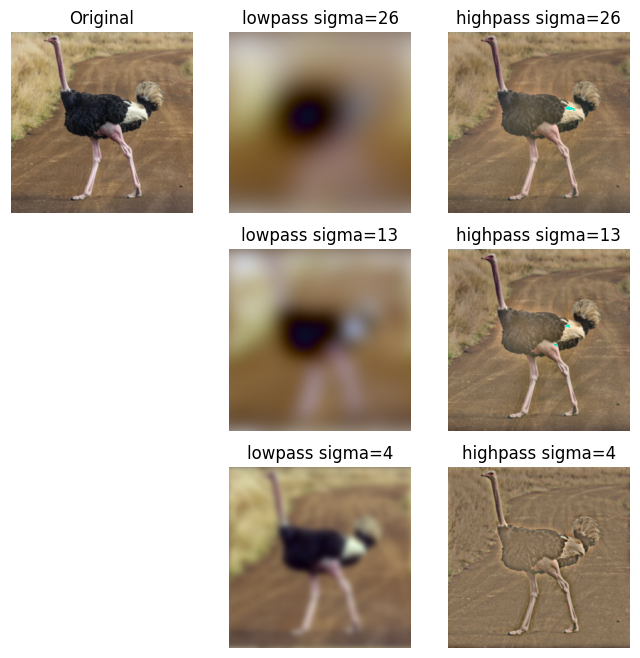

In [32]:
plt.figure(figsize=(8,8))
plt.subplot(3,3,1)
plt.imshow(image_mat)
plt.axis('equal')
plt.axis('off')
plt.title('Original');

pi = 1
for lps, hps in zip(lowpass_sigmas, highpass_sigmas):
    
    f_lp_freq = filter_utils.filter_lowpass(image_mat, lps)
    f_hp_freq = filter_utils.filter_highpass(image_mat, hps)

    pi+=1
    plt.subplot(3,3,pi)
    plt.imshow(f_lp_freq)
    plt.axis('equal')
    plt.axis('off')
    plt.title('lowpass sigma=%d'%lps);

    pi+=1
    plt.subplot(3,3,pi)
    plt.imshow(f_hp_freq)
    plt.axis('equal')
    plt.axis('off')
    plt.title('highpass sigma=%d'%hps);
    
    pi+=1

In [33]:
lps = lowpass_sigmas[0]

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


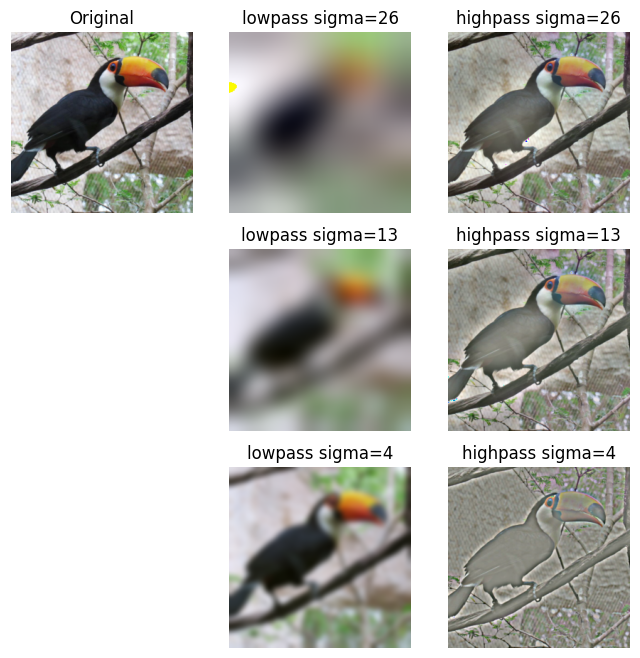

In [9]:
plt.figure(figsize=(8,8))
plt.subplot(3,3,1)
plt.imshow(image_mat)
plt.axis('equal')
plt.axis('off')
plt.title('Original');

pi = 1
for lps, hps in zip(lowpass_sigmas, highpass_sigmas):
    
    f_lp_freq = filter_utils.filter_lowpass_spatial(image_mat, lps)
    f_hp_freq = filter_utils.filter_highpass_spatial(image_mat, hps)

    pi+=1
    plt.subplot(3,3,pi)
    plt.imshow(f_lp_freq)
    plt.axis('equal')
    plt.axis('off')
    plt.title('lowpass sigma=%d'%lps);

    pi+=1
    plt.subplot(3,3,pi)
    plt.imshow(f_hp_freq)
    plt.axis('equal')
    plt.axis('off')
    plt.title('highpass sigma=%d'%hps);
    
    pi+=1

#### checking the filters on some noise images

In [5]:
npix=256
noise_images = np.random.normal(0,1,[100, npix, npix, 3])

In [6]:
sigma = 5

lp = []
hp = []

for ii in range(noise_images.shape[0]):
    
    image_mat = noise_images[ii]
    
    f_lp_freq = filter_utils.filter_lowpass(image_mat, sigma)
    f_hp_freq = filter_utils.filter_highpass(image_mat, sigma)
    
    lp += [f_lp_freq]
    hp += [f_hp_freq]
    
    
lp = np.real(np.moveaxis(np.array(lp), [0], [3]))
hp = np.real(np.moveaxis(np.array(hp), [0], [3]))


(0.0, 256.0, 0.0, 256.0)

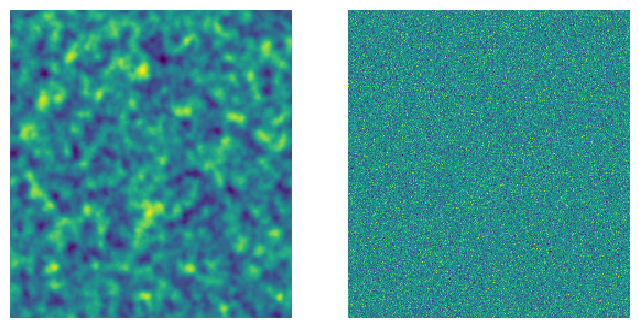

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
mean = np.mean(np.mean(lp, axis=2), axis=2)
plt.pcolormesh(mean)
plt.axis('off')

plt.subplot(1,2,2)
mean = np.mean(np.mean(hp, axis=2), axis=2)
plt.pcolormesh(mean)
plt.axis('off')

In [9]:

lp_fft = np.real(np.fft.fftshift(np.fft.fft2(lp, axes=(0,1)), axes=(0,1)))
mean_lp_fft = np.mean(np.mean(lp_fft, axis=2), axis=2)

hp_fft = np.real(np.fft.fftshift(np.fft.fft2(hp, axes=(0,1)), axes=(0,1)))
mean_hp_fft = np.mean(np.mean(hp_fft, axis=2), axis=2)


(0.0, 256.0, 0.0, 256.0)

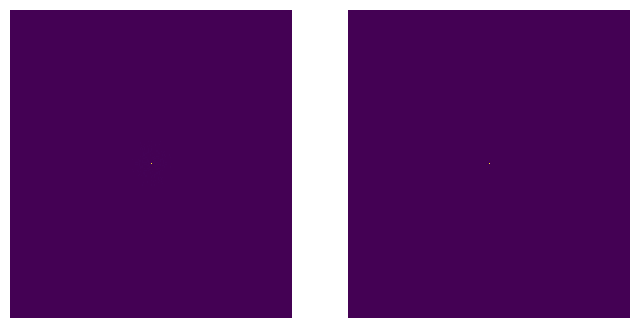

In [10]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.pcolormesh(mean_lp_fft)
plt.axis('off')

plt.subplot(1,2,2)
plt.pcolormesh(mean_hp_fft)
plt.axis('off')

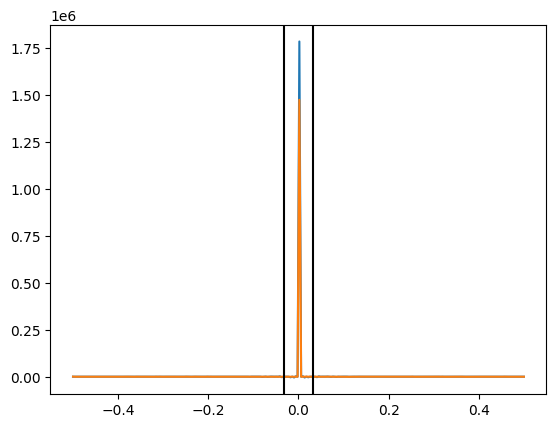

In [11]:
cutoff = 1/(2*np.pi*sigma)
# cutoff = 1/sigma

xfreq = np.linspace(-0.5, 0.5, npix)

plt.figure()
plt.plot(xfreq, mean_lp_fft[128,:])
plt.plot(xfreq, mean_hp_fft[128,:])
plt.axvline(cutoff, color='k')
plt.axvline(-cutoff, color='k')

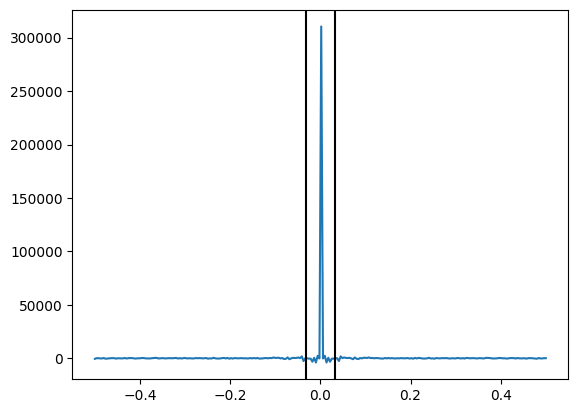

In [12]:
cutoff = 1/(2*np.pi*sigma)

xfreq = np.linspace(-0.5, 0.5, npix)

plt.figure()
plt.plot(xfreq, mean_lp_fft[128,:] - mean_hp_fft[128,:])
plt.axvline(cutoff, color='k')
plt.axvline(-cutoff, color='k')

In [13]:
npix = 256
sigma = 15

xfreq = np.abs(np.linspace(-0.5, 0.5, npix))
yfreq = np.abs(np.linspace(-0.5, 0.5, npix))
xgrid, ygrid = np.meshgrid(xfreq, yfreq)

# Frequency domain representation of the gaussian kernel has a sigma, related to the 
# spatial domain sigma by: sigma_spat = 1/(2*pi*sigma_freq)
sigma_freq = 1/(2*np.pi*sigma)

lp_gauss = np.exp(-((xgrid)**2 + (ygrid)**2)/(2*sigma_freq**2))
lp_gauss /= np.max(lp_gauss)
# highpass filter is 1-lowpass filter
hp_gauss = 1 - lp_gauss
# hp_gauss /= np.sum(hp_gauss)
filter_freq = hp_gauss

In [26]:
np.min(lp_gauss), np.max(lp_gauss)

(0.0, 1.0)

In [18]:
filter_freq[128,128]

0.03357432094094048

In [23]:
np.max(filter_freq)

1.0

In [25]:
filter_freq[126:131, 126:131]

array([[0.23906477, 0.12768399, 0.12768399, 0.23906477, 0.42097758],
       [0.12768399, 0.        , 0.        , 0.12768399, 0.33622402],
       [0.12768399, 0.        , 0.        , 0.12768399, 0.33622402],
       [0.23906477, 0.12768399, 0.12768399, 0.23906477, 0.42097758],
       [0.42097758, 0.33622402, 0.33622402, 0.42097758, 0.55940145]])